### Abstract. 

Classification of remote sensing multichannel images remains a challenging task due to the influence of several factors, including image compression and noise. In this study, we replicate and expand upon the previously conducted research on the classification of compressed noisy three-channel images by evaluating the potential of a new classifier based on the combination of Local Binary Patterns (LBP), color features, and the XGBoost algorithm. Specifically, we investigate the following factors: 1) the effect of residual noise after applying lossy compression to noisy images; 2) the impact of training a classifier on data that matches the quality conditions of the target compressed images; and 3) the benefits of post-filtering to improve the quality of compressed images before classification. Our experiments, conducted on Sentinel data with artificially added additive white Gaussian noise, demonstrate that the proposed LBP+Color+XGBoost classifier achieves competitive performance in handling noisy and compressed images. We confirm the importance of aligning classifier training with the quality conditions of the target images and highlight scenarios in which post-filtering can further enhance classification accuracy. These findings provide insights into the robustness of the LBP+Color+XGBoost pipeline for remote sensing data tasks involving challenging noise and compression conditions.

### Action Plan (in English)

1. **Develop a function to add Gaussian noise:**  
   Create a function that simulates the addition of Additive White Gaussian Noise (AWGN) to multichannel images.  

2. **Develop a function for image compression:**  
   Implement a function to compress images using lossy compression methods, such as JPEG or similar, with adjustable compression ratio parameters.

3. **Evaluate compressed images using PSNR:**  
   Develop a function to calculate the **Peak Signal-to-Noise Ratio (PSNR)** for compressed images. Use this function to identify the optimal compression ratio that yields the maximum PSNR value.

4. **Pixel-wise classification using the new classifier:**  
   Once the optimal compression point is determined, perform pixel-wise classification on the images using the proposed classifier **LBP+Color+XGBoost**. Analyze the classification results and assess the effectiveness of the new approach.

### Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import warnings
# Вимкнути всі попередження для видаленн зайвої інформації з консолі
warnings.filterwarnings('ignore')

In [3]:
def add_awgn_noise(image, sigma):
    """
    Додає Additive White Gaussian Noise (AWGN) шум до зображення.
    
    :param image: Вхідне RGB-зображення у форматі NumPy масиву.
    :param sigma: Стандартне відхилення шуму (дисперсія визначається як sigma^2).
    :return: Зображення з доданим шумом.
    """
    # Переконатися, що зображення є дійсним NumPy масивом
    if not isinstance(image, np.ndarray):
        raise ValueError("Input image should be a NumPy array.")
    
    # Генерувати шум з нормальним розподілом
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    
    # Додавати шум до зображення
    noisy_image = image.astype(np.float32) + noise
    
    # Обмежити значення пікселів у діапазоні [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255)
    
    # Перетворити назад до оригінального формату даних
    return noisy_image.astype(image.dtype)

In [4]:
def display_image(image, title='', cmap=None):
    """
    Відображає зображення в Jupyter Notebook за допомогою Matplotlib.
    
    :param image: Зображення у форматі NumPy масиву.
    :param title: Назва зображення.
    :param cmap: Кольорова карта; використовуйте 'gray' для монохромних зображень.
    """
    # Визначаємо, чи зображення кольорове (три канали) або градація сірого
    plt.figure(figsize=(10, 10))
    if len(image.shape) == 2:  # Градація сірого (одноканальне зображення)
        plt.imshow(image, cmap=cmap or 'gray')
    elif len(image.shape) == 3 and image.shape[2] == 3:  # RGB зображення
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Конвертуємо з BGR в RGB для відображення
    else:
        raise ValueError("Unsupported image shape. Make sure the image is grayscale or RGB.")
    plt.title(title)
    plt.axis('off')
    plt.show()

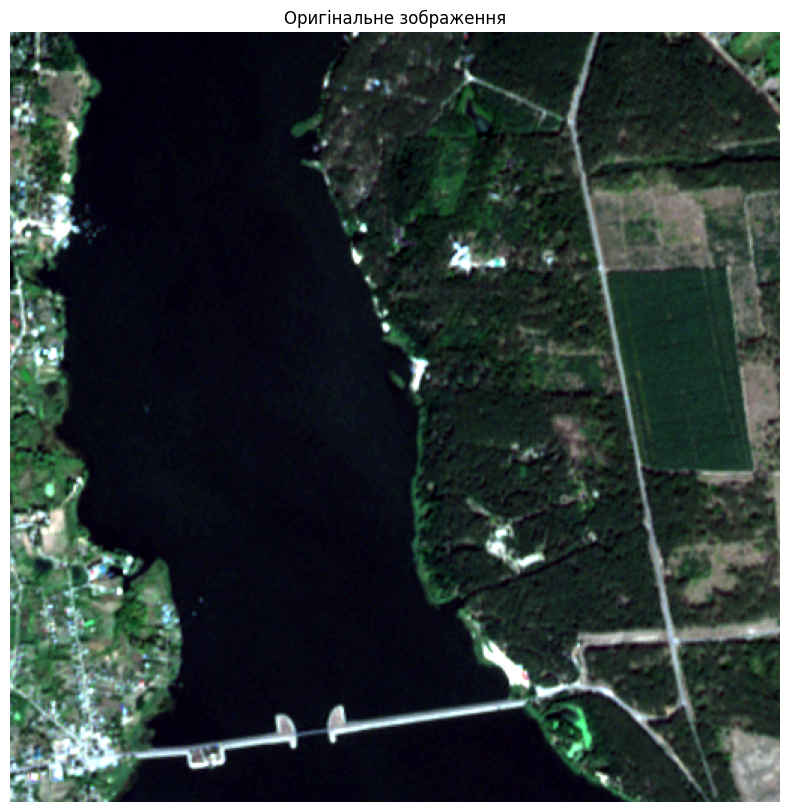

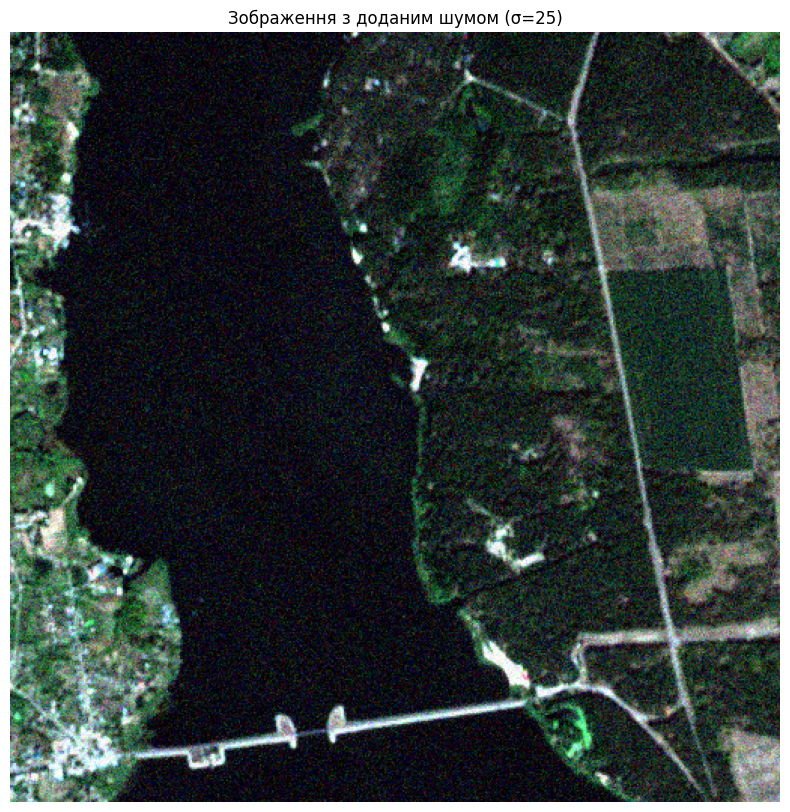

In [5]:
# Приклад використання
if __name__ == "__main__":
    # Завантажити тестове RGB-зображення
    # Замість "example.jpg" використовуйте шлях до вашого RGB-зображення
    image = cv2.imread("Images/sentinel/SS1/SS1.bmp", cv2.IMREAD_COLOR)  # Завантажуємо в BGR форматі
    
    # Відобразити оригінальне зображення
    display_image(image, title="Оригінальне зображення")
    
    # Додати AWGN шум із sigma=25
    sigma = 25
    noisy_image = add_awgn_noise(image, sigma)
    
    # Відобразити шумлене зображення
    display_image(noisy_image, title=f"Зображення з доданим шумом (σ={sigma})")